In [28]:
import util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%precision 4
%matplotlib inline
from pystan import StanModel

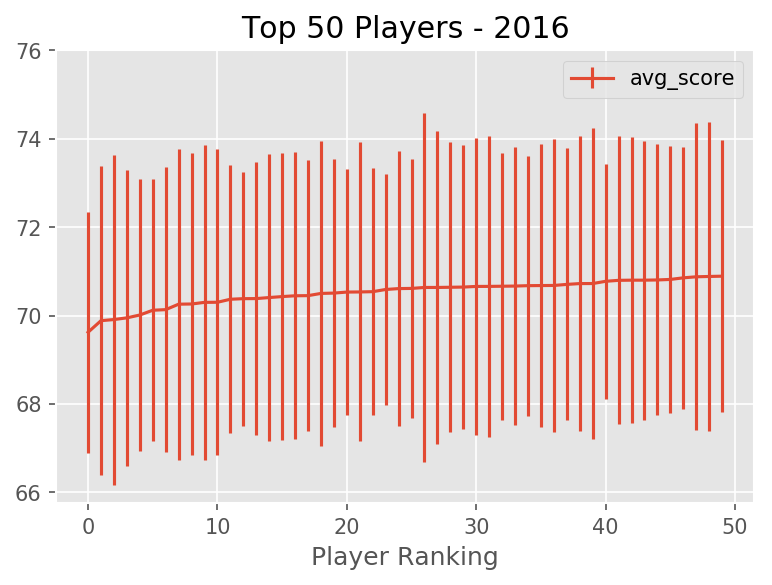

In [4]:
scores_df = pd.DataFrame.from_csv(path='db/top50-scores.txt')
plt.errorbar(range(0, len(scores_df)), scores_df['avg_score'], scores_df['std_score'])
y_low, y_high = plt.gca().get_ylim()
plt.gca().set_ylim([y_low,y_high+1])
plt.title('Top 50 Players - 2016', loc='center')
plt.xlabel('Player Ranking')
util.scale_plot_size(1.5)
foo = plt.legend(loc='upper right')

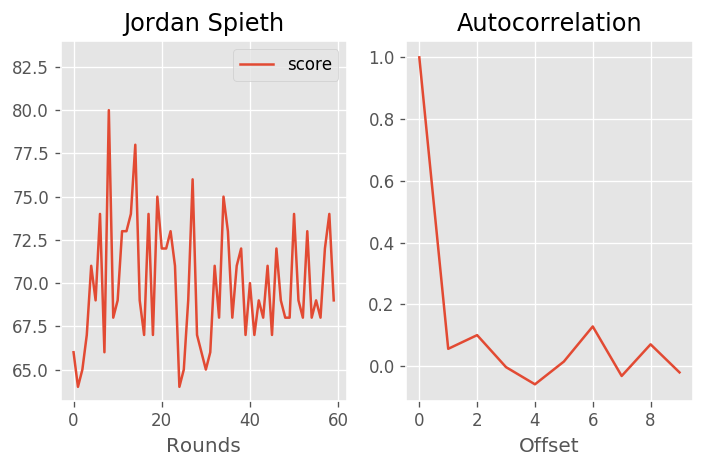

In [18]:
player_df = pd.DataFrame.from_csv(path='db/spieth-scores.txt')
min_score, max_score = player_df['score'].min(), player_df['score'].max()
util.scale_plot_size(1.2)
plt.subplot(1, 2, 1)
plt.plot(range(0, len(player_df)), player_df['score'])
y_bottom, _ = plt.gca().get_ylim()
plt.gca().set_ylim([y_bottom,max_score+4])
plt.title('Jordan Spieth', loc='center')
plt.legend(loc='upper right')
plt.xlabel('Rounds')
plt.subplot(1, 2, 2)
r = range(0, 10)
plt.title('Autocorrelation', loc='center')
plt.xlabel('Offset')
foo = plt.plot(r, [player_df['score'].autocorr(i) for i in r])
plt.tight_layout()

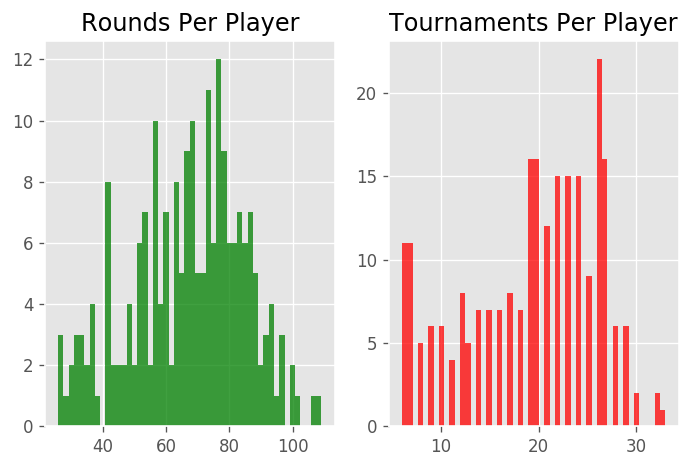

In [17]:
rounds_df = pd.DataFrame.from_csv(path='db/rounds-per-player.txt')
tourns_df = pd.DataFrame.from_csv(path='db/tourn-per-player.txt')
plt.subplot(1, 2, 1)
plt.hist(rounds_df['count'].as_matrix().tolist(), 50, facecolor='green', alpha=0.75)
foo = plt.title('Rounds Per Player')
plt.subplot(1, 2, 2)
plt.hist(tourns_df['count'].as_matrix().tolist(), 50, facecolor='red', alpha=0.75)
foo = plt.title('Tournaments Per Player')
plt.tight_layout()

In [21]:
scores = pd.DataFrame.from_csv(path='db/multi-scores-input.txt')
num_scores = len (scores)
player_ids = scores['player_id'].unique()
num_players = len (player_ids)
player_map = dict(zip(player_ids, range(1,num_players + 1)))
player_map_reverse = dict(zip(range(1,num_players + 1), player_ids ))
tournament_ids = scores['permanent_tournament_id'].unique()
num_tournaments = len (tournament_ids)
tournament_map = dict(zip(tournament_ids, range(1, num_tournaments + 1)))
tournament_map_reverse = dict(zip(range(1, num_tournaments + 1), tournament_ids))
dat = sorted([[player_map[i[0]], tournament_map[i[4]], i[6]] for i in scores.as_matrix()], key = lambda (el): el[0])
player_field, tourn_field, score = zip(*dat)

In [51]:
code = """
data {
  int N;           // total number of scores
  int N_P;         // number of players
  int N_T;         // number of tournaments
  real y[N];        // score
  int p[N];        // player identification 
  int t[N];        // tournament identification
}
parameters {
  vector[N_T] alpha;                      // tournament offsets
  vector<lower=0, upper=7>[N_P] sigma;    // player score deviation
  vector<lower=65, upper=75>[N_P] tau;    // normalized player score
} 
model {
  alpha ~ normal(0, 2);
  y ~ normal(alpha[t] + tau[p], sigma[p]);   
}

"""
data = {
    'N': num_scores,
    'y': score,
    'p' : player_field,
    't' : tourn_field,
    'N_P' : num_players,
    'N_T' : num_tournaments
}
stan_model = StanModel(model_code=code);


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e43c5738085749d73fb7b7ca68d684c5 NOW.


In [55]:
fit = stan_model.sampling(data=data, iter=1000, chains=4)
params = fit.summary()['summary']
t_range = range(0,num_tournaments)
d = {
    'permanent_tournament_id': pd.Series([tournament_map_reverse[i+1] for i in t_range]),
    'alpha_mean': pd.Series([round(params[i][0],3) for i in t_range]),
    'alpha_se': pd.Series([round(params[i][1],3) for i in t_range]),
    'alpha_sd': pd.Series([round(params[i][2],3) for i in t_range])
}
t_stats_df = pd.DataFrame(d)
p_range = range(0,num_players)
d = {
    'player_id': pd.Series([player_map_reverse[i+1] for i in p_range]),
    'sigma_mean': pd.Series([round(params[i+num_tournaments][0],3) for i in p_range]),
    'sigma_se': pd.Series([round(params[i+num_tournaments][1],3) for i in p_range]),
    'sigma_sd': pd.Series([round(params[i+num_tournaments][2],3) for i in p_range]),
    'tau_mean': pd.Series([round(params[i+num_tournaments+num_players][0],3) for i in p_range]),
    'tau_se': pd.Series([round(params[i+num_tournaments+num_players][1],3) for i in p_range]),
    'tau_sd': pd.Series([round(params[i+num_tournaments+num_players][2],3) for i in p_range])
}
p_stats_df = pd.DataFrame(d)

In [40]:
p_df = pd.DataFrame.from_csv(path='db/multi-analysis.txt')  # player view with stan results and raw stats

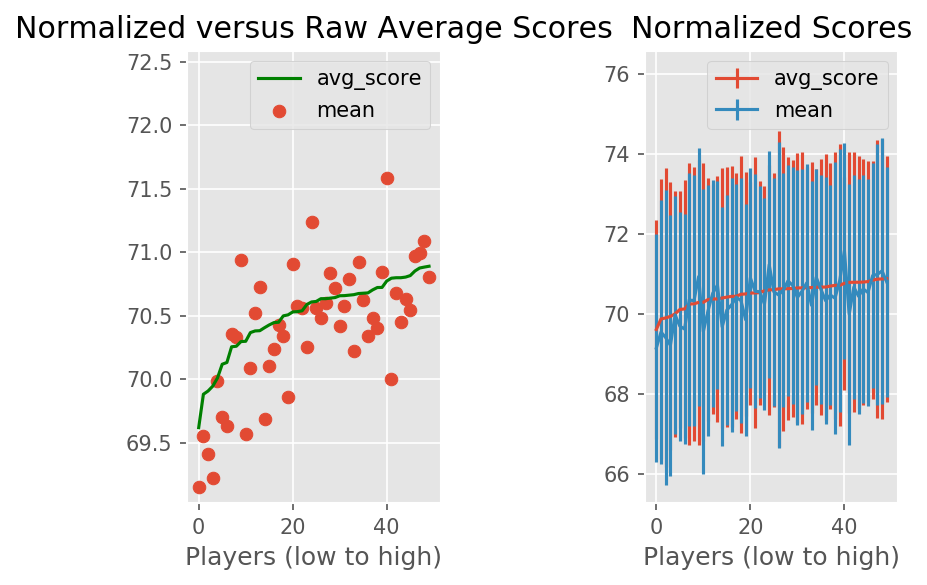

In [47]:
plt.subplot(1, 2, 1)
plt.scatter(range(0, len(p_df)), p_df['mean'])
plt.plot(range(0, len(p_df)), p_df['avg_score'], color='green')
plt.xlabel('Players (low to high)')
plt.legend(loc='upper right')
y_bottom, _ = plt.gca().get_ylim()
plt.gca().set_ylim([y_bottom,p_df['mean'].max()+1])
plt.title('Normalized versus Raw Average Scores', loc='center')
plt.subplot(1, 2, 2)
plt.errorbar(range(0, len(p_df)), p_df['avg_score'], p_df['std_score'])
plt.errorbar(range(0, len(p_df)), p_df['mean'], p_df['std'])
plt.xlabel('Players (low to high)')
plt.legend(loc='upper right')
y_bottom, _ = plt.gca().get_ylim()
plt.gca().set_ylim([y_bottom,p_df['mean'].max()+5])
plt.title('Normalized Scores', loc='center')
util.scale_plot_size(1.25)
plt.tight_layout()

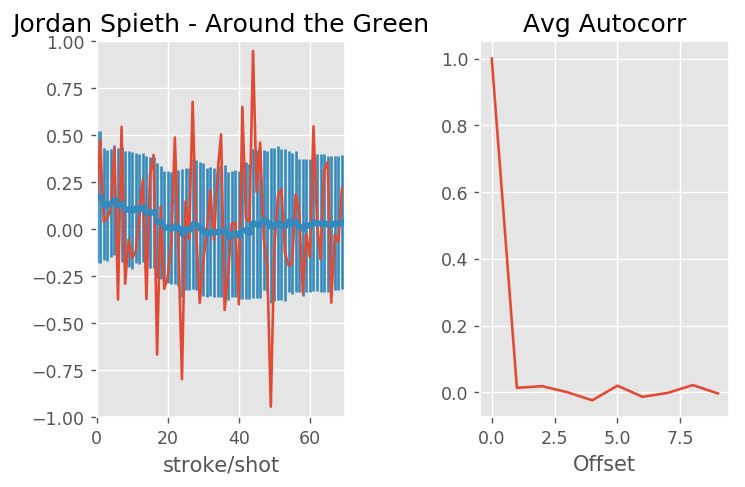

In [70]:
spieth_sg_df = pd.DataFrame.from_csv(path='db/spieth-shot-sg.txt')
sg = spieth_sg_df['sg']
plt.subplot(1,2,1)
window = 30
rolling = sg.rolling(window).mean().as_matrix()[window:]
std_roll = sg.rolling(window).std().as_matrix()[window:]
sg = sg[window:]
plt.plot(range(0, len(sg)), sg)
plt.errorbar(range(0, len(rolling)), rolling, std_roll, linestyle=None, marker=".")
plt.axis([0, len (sg), -1.0, 1])
plt.title('Jordan Spieth - Around the Green', loc='center')
plt.xlabel('stroke/shot')
plt.subplot(1,2,2)
r = range(0, 10)
plt.title('Avg Autocorr', loc='center')
plt.xlabel('Offset')
df_auto = pd.DataFrame.from_csv(path='db/avg-autocorr.txt')
plt.plot(r, df_auto['correlation'])
plt.tight_layout()


In [78]:
sg_df = pd.DataFrame.from_csv(path='db/spieth-sg.txt')
sg_df.corr()

,sg_tee,sg_approach,sg_around,sg_putting
sg_tee,1.000000,0.299140,-0.021931,0.007695
sg_approach,0.299140,1.000000,0.110526,-0.117694
sg_around,-0.021931,0.110526,1.000000,0.101885
sg_putting,0.007695,-0.117694,0.101885,1.000000


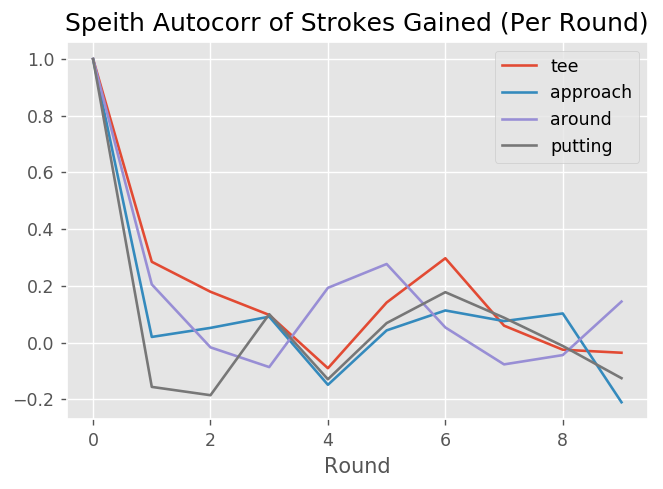

In [79]:
r = range(0, 10)
plt.plot(r, [ sg_df['sg_tee'].autocorr(i) for i in r], label='tee')
plt.plot(r, [ sg_df['sg_approach'].autocorr(i) for i in r], label='approach')
plt.plot(r, [ sg_df['sg_around'].autocorr(i) for i in r], label='around')
plt.plot(r, [ sg_df['sg_putting'].autocorr(i) for i in r], label='putting')
plt.legend(loc='upper right')
plt.title('Speith Autocorr of Strokes Gained (Per Round)')
foo = plt.xlabel('Round')

In [81]:
scores = pd.DataFrame.from_csv(path='db/sg-regression-input.txt')
num_scores = len (scores)
player_ids = scores['player_id'].unique()
num_players = len (player_ids)
player_map = dict(zip(player_ids, range(1,num_players + 1)))
player_map_reverse = dict(zip(range(1,num_players + 1), player_ids, ))
tournament_ids = scores['permanent_tournament_id'].unique()
num_tournaments = len (tournament_ids)
tournament_map = dict(zip(tournament_ids, range(1, num_tournaments + 1)))
tournament_map_reverse = dict(zip(range(1, num_tournaments + 1), tournament_ids))
x = np.ones((num_scores,1))
datum = sorted([[player_map[i[0]], tournament_map[i[4]], i[6], i[7], i[8], i[9], i[10]] for i in scores.as_matrix()], key = lambda (el): el[0])
p, t, y, x1, x2, x3, x4 = zip(*datum)
x = np.column_stack((x, x1))
x = np.column_stack((x, x2))
x = np.column_stack((x, x3))
x = np.column_stack((x, x4))

In [82]:
code = """
data {
  int N;       // number of rounds (scores)
  int N_P;     // number of players
  int N_T;     // number of tournaments
  int y[N];    // scores
  int p[N];    // player field value
  int t[N];    // tournament field value
  matrix[N, 5] x;  // 1 column and strokes gained totals for each category for each score/player
}
# 
parameters {
  matrix [N_T, 5] b;     // linear regression coefficients 
  real<lower=0, upper=4> sigma;   //  white noise term
} 
model {
  for (n in 1:N) {
    b[t[n]][1] ~ normal(70, 5);
    for (k in 2:5) {
      b[t[n]][k] ~ normal(0, 5);
    }
     y[n] ~ normal((x[n])*(b[t[n]])', sigma);
  }
}

"""
data = {
    'N': num_scores,
    'y': y,
    'p' : p,
    't' : t,
    'N_P' : num_players,
    'N_T' : num_tournaments,
    'x' : x
}

stan_model = StanModel(model_code=code);


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb0ce365f1f7cd5cc00b92aeca6114dd NOW.


In [84]:
fit = stan_model.sampling(data=data, iter=1000, chains=4)
params = fit.summary()['summary']

In [89]:
t_range = range(0,num_tournaments)
d = {
    'permanent_tournament_id': pd.Series([tournament_map_reverse[i+1] for i in t_range]),
    'offset': pd.Series([round(params[i][0],3) for i in t_range]),
    'tee': pd.Series([round(params[i+num_tournaments][0],3) for i in t_range]),
    'approach': pd.Series([round(params[i+2*num_tournaments][0],3) for i in t_range]),
    'around': pd.Series([round(params[i+3*num_tournaments][0],3) for i in t_range]),
    'putting': pd.Series([round(params[i+4*num_tournaments][0],3) for i in t_range])
}
t_df = pd.DataFrame(d)

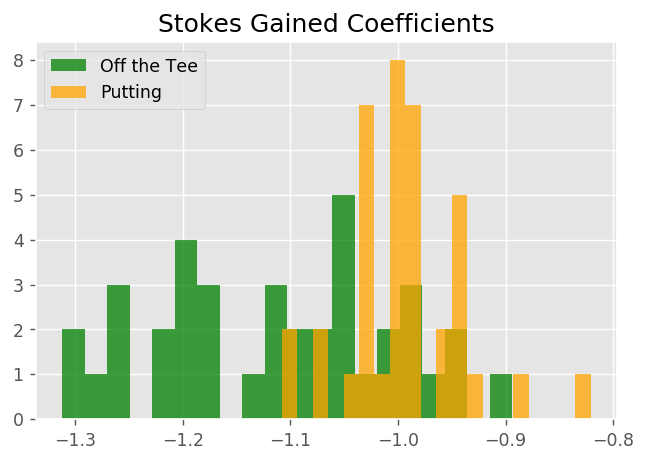

In [91]:
plt.hist(t_df['tee'].as_matrix().tolist(), 20, facecolor='green', alpha=0.75, label='Off the Tee')
plt.hist(t_df['putting'].as_matrix().tolist(), 20, facecolor='orange', alpha=0.75,  label='Putting')
plt.legend(loc='upper left')
foo = plt.title('Stokes Gained Coefficients')

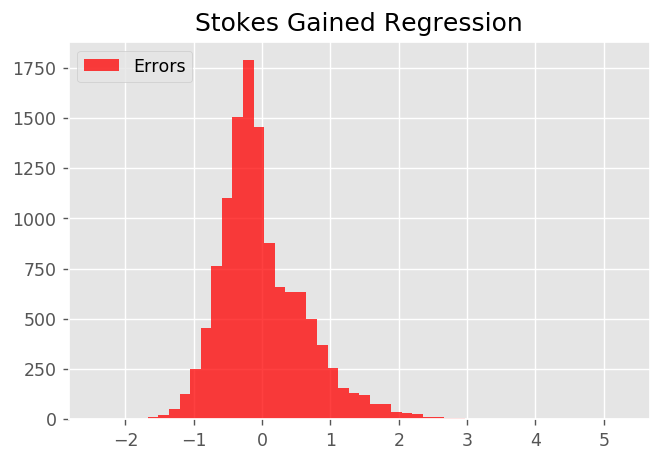

In [95]:
p_df = pd.DataFrame.from_csv(path='db/regression-prediction.txt')
t_df = pd.DataFrame.from_csv(path='db/tournament_coef.txt')
sg_map = {}
for row in t_df.as_matrix():
    sg_map[int(row[0])] = row
p_df = pd.DataFrame.from_csv(path='db/regression-prediction.txt')
player_scores = p_df.as_matrix()
player_id = [row[0] for row in player_scores ]
actuals = [row[6] for row in player_scores]
def compute_score(row):
    sg = sg_map[int(row[4])]
    return sg[1] + row[7]*sg[2] + row[8]*sg[3] + row[9]*sg[4] + row[10]*sg[5]

estimated = [compute_score(row) for row in player_scores]
comp_df = pd.DataFrame({'player_id': player_id, 'actuals':actuals, 'estimated': estimated})
h = [row[0] - row[1] for row in comp_df.as_matrix()]
plt.hist(h, 50, facecolor='red', alpha=0.75,  label='Errors')
plt.legend(loc='upper left')
foo = plt.title('Stokes Gained Regression')

In [ ]:
code = '''
data {
    int sg_n;
    int<lower=2> N;
    matrix[sg_n,N] y;
    vector[sg_n+1] s_coef;
}
parameters {
    vector[sg_n] alpha;
    vector[sg_n] beta;
    vector<lower=0>[sg_n] sigma;
    vector[sg_n] y_tilda;
} 
model {
    for (k in 1:sg_n) {
        for (n in 2:N) {
            y[k][n] ~ normal(alpha[k]+ beta[k] * y[k][n-1], sigma[k]);
        }
    }
    for (j in 1:sg_n) {
        y_tilda[j] ~ normal(alpha[j]+ beta[j] * y[j][N], sigma[j]);
    }
}
generated quantities {
    real score_predict;
    score_predict = s_coef[1] + s_coef[2]*y_tilda[1] + s_coef[3]*y_tilda[2] 
                + s_coef[4]*y_tilda[3] + s_coef[5]*y_tilda[4];
}
'''